In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from admm import run_admm
%load_ext pyinstrument

# autoreload for debugging
%load_ext autoreload
%autoreload 2

In [108]:
# generate a gaussian mixture model with 2 components, one with weight .8 and
# the other with weight .2. The mean of the first should be .2, and the mean of 
# the second should be -.2. There should be d dimensions, and the covariance is
# the identity in the first, and sigma * identity in the second.
def generate_gmm(m, d, sigma):
    X = np.random.randn(m, d)
    y = np.random.binomial(1, .8, m)
    X[y == 1] += .2
    X[y == 0] -= .2
    X[y == 0] *= sigma

    # compute the empirical covariance matrix
    P = np.cov(X.T)
    # compute the mean of the data
    q = np.mean(X, axis=0)
    
    return -X, P, -q

In [127]:
np.random.seed(0)
m = 100_000
d = 1000
A, P, q = generate_gmm(m, d, 2)

beta = .1
kappa = .2

k = int(beta * m)
alpha = kappa * k

gamma = .05

A_box = np.eye(d)
A_total = np.ones((1, d))

def box_prox(z):
    return np.clip(z, 0, lim)

def total_prox(z):
    return np.clip(z, 0, 1)

proj_As = [A_box, A_total]
proj_fns = [box_prox, total_prox]

lim = 1
def gen_constraints(x):
    return [
        0 <= cp.sum(x), cp.sum(x) <= 1,
        0 <= x, x <= lim,
    ]

def gen_objective(x):
    return cp.Minimize(.5 * cp.quad_form(x, gamma*P) + q @ x)

In [128]:
q.max(), q.min(), kappa, A.max(), A.min()

(-0.06746340212706711,
 -0.09354192348533061,
 0.2,
 10.919361215062876,
 -10.490861349815166)

In [129]:
# solve the problem with cvxpy for reference
x_cvxpy = cp.Variable(d)
objective = gen_objective(x_cvxpy)
constraints = gen_constraints(x_cvxpy)
constraints += [
    cp.sum_largest(A@x_cvxpy, k) <= alpha ,
]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=True)
print(prob.value)
# print the sum of the largest k elements of A @ x_cvxpy.value
print(np.sort(A @ x_cvxpy.value)[::-1][:k].sum() / m, kappa)

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) Apr 26 03:53:24 PM: Your problem has 1000 variables, 5 constraints, and 0 parameters.
(CVXPY) Apr 26 03:53:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 26 03:53:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 26 03:53:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 26 03:53:24 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 26 03:53:24 PM: Compiling problem (target solver=MOSEK).
(

In [131]:
# warm start with fewer scenarios
m_ = 10_000
A_ = A[:m_]
k_ = int(beta * m_)
alpha_ = kappa * k_
x_cvxpy_ = cp.Variable(d)

objective = gen_objective(x_cvxpy_)
constraints = gen_constraints(x_cvxpy_)
constraints += [
    cp.sum_largest(A_@x_cvxpy_, k_) <= alpha_ , 
]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK)
print(prob.value)
print(np.sort(A_ @ x_cvxpy_.value)[::-1][:k].sum() / m_, kappa)

-0.039581217736143225
-0.04253135173481724 0.2


In [137]:
# %%pyinstrument

x, history = run_admm(
     gamma*P, q, A, beta, kappa, proj_As, proj_fns, max_iter=2_000, alpha_over=1.7, rho=1, warm=x_cvxpy_.value
)

print(history["objval"][-1])
print(np.sort(A @ x)[::-1][:k].sum() / m, kappa)

print("relative objective error: ", abs(history["objval"][-1] - prob.value) / abs(prob.value))

iter: 0, objval: -0.03959304413208966, r_norm: 0.2755404508204109, s_norm: 35.38947392165406, u_norm: 0.27593017232545647, time: 1.873227834701538
iter: 100, objval: -0.03470275309468368, r_norm: 0.0011047048221381655, s_norm: 0.39224694784296027, u_norm: 0.010300180609767139, time: 5.7761359214782715
iter: 200, objval: -0.03623576764248194, r_norm: 0.0004800596556145363, s_norm: 0.026153237317135737, u_norm: 0.019579807547496147, time: 9.71803593635559
iter: 300, objval: -0.0365019196675744, r_norm: 0.000461250106208867, s_norm: 0.012333562108670692, u_norm: 0.02021160487217554, time: 13.628016710281372
iter: 400, objval: -0.03660294328201877, r_norm: 0.0003447333110439005, s_norm: 0.005578004847218186, u_norm: 0.02785289402419325, time: 17.837381839752197
iter: 500, objval: -0.036636703526568656, r_norm: 0.0002558836111656419, s_norm: 0.002204739722523616, u_norm: 0.046998687572726544, time: 22.183793783187866
ADMM terminated after  500  iterations
Time:  22.214370012283325
-0.036636

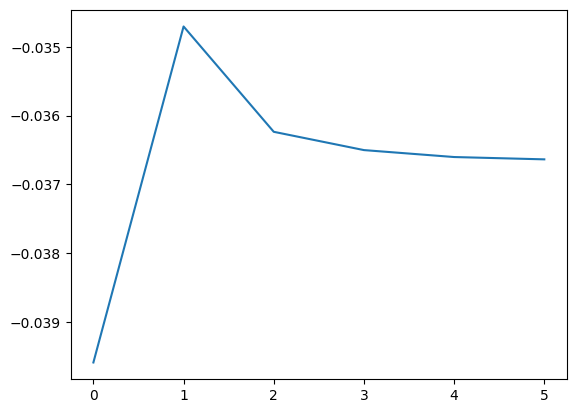

In [138]:
plt.plot(history["objval"])

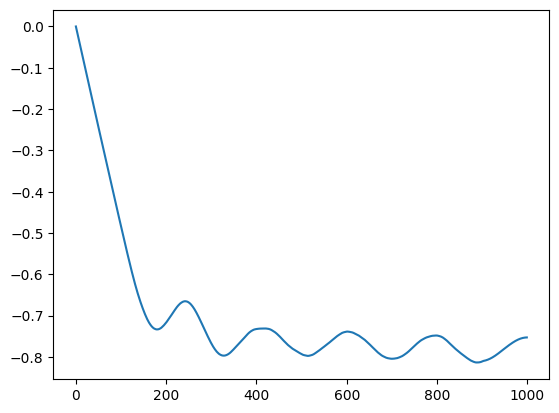

In [98]:
# plt.plot(history["objval"]) # 100k .7 rho

In [121]:
x.min(), x.max(), x.sum(), x_cvxpy.value.min(), x_cvxpy.value.max(), x_cvxpy.value.sum()

(-9.239992264822045e-06,
 0.017336139567720708,
 0.30837140521800793,
 3.911073296449167e-09,
 0.017803137069810192,
 0.30719016637160734)

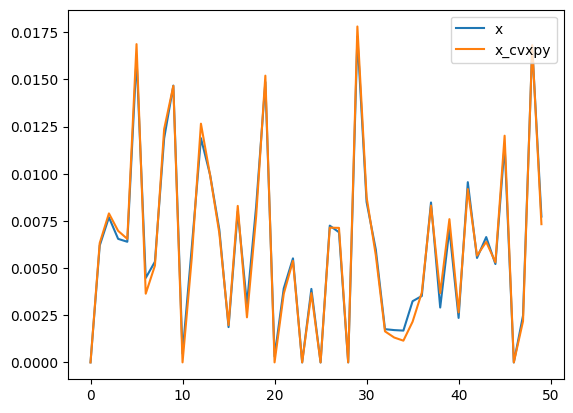

In [126]:
plt.plot(x, label="x")
plt.plot(x_cvxpy.value, label="x_cvxpy")
plt.legend()